In [172]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, lasso_path, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [173]:
rng = np.random.default_rng(0)
n = 100
X = rng.normal(size=n)
eps = rng.normal(size=n)

In [174]:
X.shape

(100,)

(-50.0, 50.0)

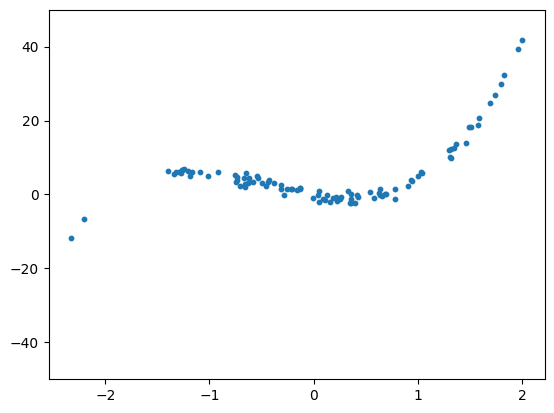

In [175]:
beta0, beta1, beta2, beta3 = 0, -5, 5, 4
Y = beta0 + beta1*X + beta2*X**2 + beta3*X**3 + eps
plt.scatter(X, Y, s=10)
plt.ylim([-50,50])

In [176]:
columns = [f'X^{i}' for i in range(1, 11)]
print(columns)

d = {name: col for name, col in zip(columns, [X**i for i in range(1, 11)])}
data = pd.DataFrame(d)
data['Y'] = Y
data.head()

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']


,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,0.125730,0.015808,0.001988,0.000250,0.000031,0.000004,4.966812e-07,6.244784e-08,7.851581e-09,9.871810e-10,-0.038978
1,-0.132105,0.017452,-0.002305,0.000305,-0.000040,0.000005,-7.021528e-07,9.275780e-08,-1.225376e-08,1.618781e-09,1.728274
2,0.640423,0.410141,0.262664,0.168216,0.107729,0.068992,4.418418e-02,2.829655e-02,1.812175e-02,1.160558e-02,-0.265047
3,0.104900,0.011004,0.001154,0.000121,0.000013,0.000001,1.397757e-07,1.466249e-08,1.538097e-09,1.613466e-10,-1.539228
4,-0.535669,0.286942,-0.153706,0.082336,-0.044105,0.023625,-1.265545e-02,6.779139e-03,-3.631377e-03,1.945217e-03,4.371274


Mallow's $C_p$ is defined as:

$$C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)$$

In [177]:
# Compute Cp
def nCp(sigma2, estimator, X, Y):
    "Cp statistic. The full model should yield p+1"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    #print('sigma2 | RSS:', sigma2, RSS)
    return (RSS + 2*p*sigma2)/n

In [178]:
# Fit model to data
def fit_model(model, X, y, sigma2):
    model_fitted = model.fit(X, y)

    Cp = nCp(sigma2, model_fitted, X, y)
    return Cp

In [179]:
# Compute sigma for the complete model
y = data['Y']

model = LinearRegression().fit(data[columns], y)
y_pred = model.predict(data[columns])
sigma2 = sum((y-y_pred)**2)/X.shape[0]

In [180]:
# Forward stepwise selection
current_columns = []
cp_values = []
for _ in range(len(columns)):
    best_cp = float('inf')
    best_col = ''
    for col in columns:
        if col not in current_columns:
            X = data[current_columns + [col]]
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp < best_cp:
                best_col = col
                best_cp = cp
            #print(cp)
    current_columns.append(best_col)
    print(current_columns)
    cp_values.append(best_cp)

print(current_columns)

['X^3']
['X^3', 'X^2']
['X^3', 'X^2', 'X^1']
['X^3', 'X^2', 'X^1', 'X^9']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7', 'X^4']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7', 'X^4', 'X^10']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7', 'X^4', 'X^10', 'X^8']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7', 'X^4', 'X^10', 'X^8', 'X^6']
['X^3', 'X^2', 'X^1', 'X^9', 'X^5', 'X^7', 'X^4', 'X^10', 'X^8', 'X^6']


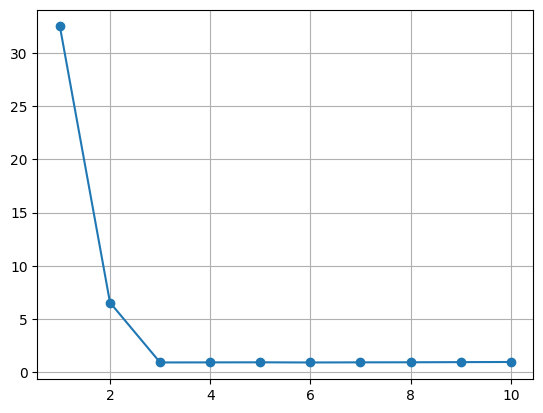

In [181]:
plt.plot(list(range(1, 11)), cp_values, marker='o')
plt.grid()

As we can see from the $C_p$ values obtained, and the plot, that we should choose only three predictors: $X_1$, $X_2$, $X_3$.

In [182]:
best_columns = ['X^1', 'X^2', 'X^3']
best_model = LinearRegression().fit(data[best_columns], y)
score = best_model.score(data[best_columns], y)
coefs = best_model.coef_
interc = best_model.intercept_
print(score, coefs, interc)

0.988247312425289 [-4.69574149  5.0004709   3.88980302] -0.0487661890034099


In [183]:
# Backwards stepwise selection
current_columns = columns[:] # Start with all columns
cp_values = []
for _ in range(len(columns)-1):
    print(current_columns)
    X = data[current_columns]
    best_cp = fit_model(LinearRegression(), X, y, sigma2)
    cp_values.append(best_cp)
    worst_col = ''
    for i, col in enumerate(columns):
        if col in current_columns:
            print('X:', current_columns[:i] + current_columns[i+1:])
            X = data[current_columns[:i] + current_columns[i+1:]] # All columns except index i
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp <= best_cp:
                worst_col = col
                best_cp = cp
            #print(cp)
    if worst_col == '':
        current_columns.pop(-1)
    else:
        current_columns.pop(current_columns.index(worst_col))
    #print(current_columns)
cp_values.append(best_cp)
print(current_columns)

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X

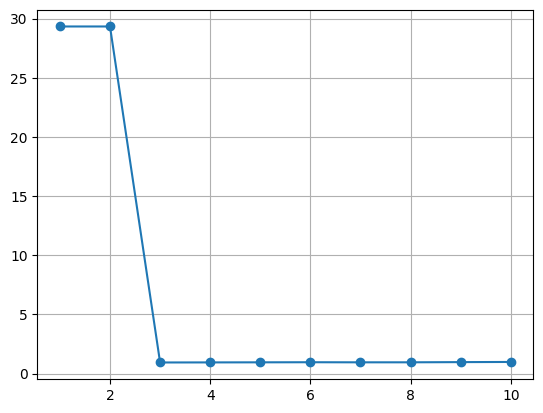

In [184]:
plt.plot(list(range(10, 0, -1)), cp_values, marker='o')
plt.grid()

In [220]:
X = data[columns]
y = data['Y']

K = 5
kfold = KFold(K, random_state=0, shuffle=True)

lassoCV = ElasticNetCV(
    n_alphas=200,
    l1_ratio=1,
    cv=kfold,
    eps=1e-8)
pipeCV = Pipeline(steps=[
    ('lasso', lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4055877424293612, tolerance: 0.7247111051849021
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6566731797315697, tolerance: 0.7247111051849021
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7636279113876299, tolerance: 0.7247111051849021
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carl

0.007944972925281206

c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7272552648137207, tolerance: 1.023563134215297
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2665893075036365, tolerance: 1.023563134215297
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carlos\Documents\Python\ISLP_Python\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2430610679948586, tolerance: 1.023563134215297
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Carlos\

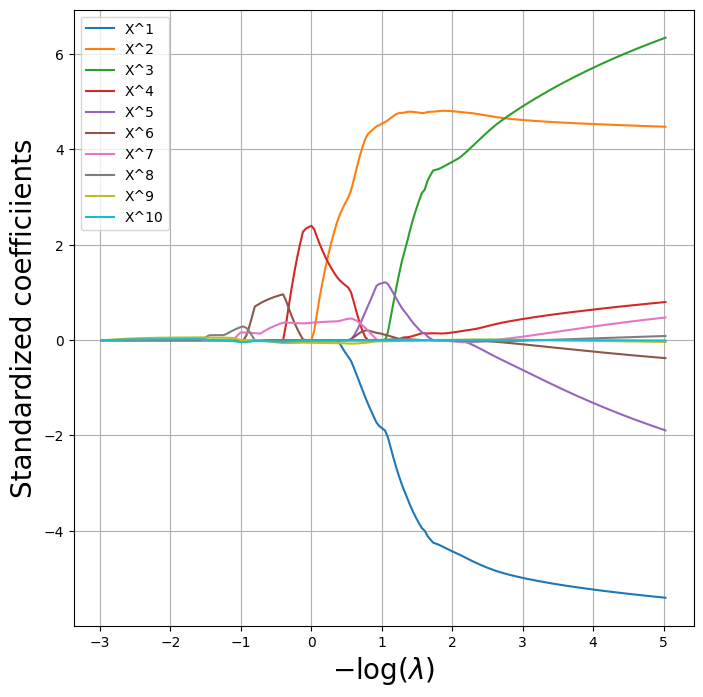

In [224]:
lambdas , soln_array = Lasso.path(
    X,
    Y,
    l1_ratio=1,
    n_alphas=200,
    eps=1e-8)[:2]
soln_path = pd.DataFrame(
    soln_array.T,
    columns=columns,
    index=-np.log10(lambdas))

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)
ax.grid()

In [221]:
tuned_lasso.alpha_

0.007944972925281206

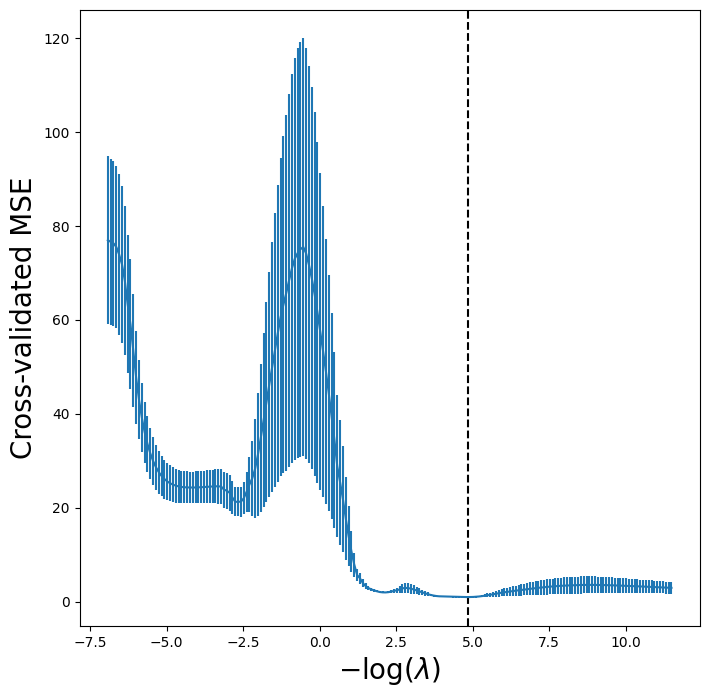

In [222]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [223]:
#min_idx = np.where(lambdas == round(tuned_lasso.alpha_, 0))
min_idx = np.where(lambdas == min(lambdas, key=lambda x: abs(x-tuned_lasso.alpha_)))
print(min_idx, lambdas[min_idx], -np.log(lambdas[min_idx]))
[a[min_idx] for a in soln_array]
tuned_lasso.coef_

(array([126], dtype=int64),) [0.00809946] [4.81595833]


array([-4.47404036e+00,  4.96773088e+00,  3.82932225e+00,  6.63953481e-02,
       -7.02714486e-02, -0.00000000e+00, -9.91647615e-04, -3.64065301e-03,
        3.84260898e-03,  6.30935958e-04])

In [206]:
-np.log(lambdas[min_idx])

array([4.26056092])

In [213]:
round(tuned_lasso.alpha_, 0), tuned_lasso.alpha_, lambdas

(16.0,
 15.724427179710126,
 array([9.41418012e+02, 8.58186144e+02, 7.82312903e+02, 7.13147704e+02,
        6.50097481e+02, 5.92621602e+02, 5.40227233e+02, 4.92465111e+02,
        4.48925695e+02, 4.09235649e+02, 3.73054646e+02, 3.40072448e+02,
        3.10006245e+02, 2.82598230e+02, 2.57613390e+02, 2.34837489e+02,
        2.14075232e+02, 1.95148590e+02, 1.77895275e+02, 1.62167346e+02,
        1.47829941e+02, 1.34760123e+02, 1.22845823e+02, 1.11984880e+02,
        1.02084165e+02, 9.30587850e+01, 8.48313489e+01, 7.73313101e+01,
        7.04943585e+01, 6.42618698e+01, 5.85804027e+01, 5.34012407e+01,
        4.86799746e+01, 4.43761211e+01, 4.04527763e+01, 3.68762990e+01,
        3.36160223e+01, 3.06439904e+01, 2.79347194e+01, 2.54649781e+01,
        2.32135896e+01, 2.11612490e+01, 1.92903582e+01, 1.75848751e+01,
        1.60301757e+01, 1.46129291e+01, 1.33209829e+01, 1.21432593e+01,
        1.10696595e+01, 1.00909780e+01, 9.19882278e+00, 8.38554410e+00,
        7.64416833e+00, 6.96833847e+